In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import numpy as np
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch.nn.utils.prune as prune

mpl.rcParams['agg.path.chunksize'] = 10000

## Simple Classifier

In [5]:
class NetSmall(nn.Module):

    def __init__(self, msk):
        super(NetSmall, self).__init__()
        self.fc1 = nn.Linear(12, 4)
        if msk:
            conn = np.zeros((12,4), dtype = np.int32)
            conn[:3,0] = 1
            conn[3:6,1] = 1
            conn[6:9,2] = 1
            conn[9:,3] = 1
            prune.custom_from_mask(self.fc1, name='weight', mask=torch.tensor(conn.T))
        self.mx = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        y = self.mx(x)
        return x, y



In [8]:
# test Net
net = NetSmall(msk=True)
print(net)
params = list(net.parameters())
for p in params:
    print(p.size())

NetSmall(
  (fc1): Linear(in_features=12, out_features=4, bias=True)
  (mx): Softmax(dim=1)
)
torch.Size([4])
torch.Size([4, 12])


## Support functionality

### Load data and set it up for training

In [19]:
def setupData(species, subj, pos = False):
    # Load data
    featureChoiceLikelihood, featureChoiceLikelihood_pos, objectChoice, rules = pickle.load( open('rawData/forObjectPred/'+species+'/' +subj+'_objPredFromFeatPred.pickle', "rb" ) )

    if pos: # version based on posterior
        featureChoiceLikelihood = featureChoiceLikelihood_pos
    
    # Randomize position of objects in input structure
    featureChoiceLikelihood = np.swapaxes(featureChoiceLikelihood, 1, 2)
    for i in range(featureChoiceLikelihood.shape[1]):
        pInds = np.random.permutation(4)
        objectChoice[:,i] = objectChoice[pInds,i]
        tmp = np.copy(featureChoiceLikelihood[:,i,:])
        for j in range(4):
            featureChoiceLikelihood[j,i,:] = tmp[pInds[j],:]

    # trials x num features (ordered in consecutive sets of 3 per object)
    featureChoiceLikelihood = np.hstack(featureChoiceLikelihood)
    print(featureChoiceLikelihood.shape)
    # trials x num objects
    objectChoice = np.swapaxes(objectChoice, 0, 1)

    # Also get index of chosen object
    objectChoice0 = objectChoice
    # trials
    objectChoice = np.nonzero(objectChoice)[1]

    return featureChoiceLikelihood, objectChoice, objectChoice0

### Live plotting to track training

In [15]:
from IPython.display import clear_output
    
def live_plot(y1, y2, figsize=(7,5), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    plt.xlim(0, len(y1))
    plt.ylim(0, 1)
    
    plt.plot(np.array(y1))
    plt.plot(np.array(y2))


    plt.title(title)
    plt.grid(True)
    plt.xlabel('axis x')
    plt.ylabel('axis y')
    plt.show();


### Train classifier

In [16]:
def trainNet(seed, featureChoiceLikelihood, objectChoice, objectChoice0, testInds):
    
    # create network
    torch.manual_seed(seed)
    net = NetSmall(msk=True)

    learningRate = 0.001
    batchSize = 1000
    np.random.seed(seed)
    np.set_printoptions(threshold=sys.maxsize)

    # create  optimizer
    optimizer = optim.Adam(net.parameters(), lr=learningRate)
    criterion = nn.CrossEntropyLoss()

    # for metrics
    losses = []
    perfTrain = []
    perfTest = []
    
    # train-validation split
    trainInds = np.setdiff1d(np.arange(objectChoice.shape[0]), testInds)
    trainInputs = np.log(featureChoiceLikelihood[trainInds,:])
    trainTargets = objectChoice[trainInds]
    trainTargets0 = objectChoice0[trainInds,:]    

    testInputs = np.log(featureChoiceLikelihood[testInds,:])
    testTargets = objectChoice[testInds]
    testTargets0 = objectChoice0[testInds,:]
    print([objectChoice.shape[0], trainInds.shape, testInds.shape])

    # Loop through training epochs
    for lp in range(100000):
        net.train()
        
        # create mini-batch
        inds = np.random.randint(0, high=trainTargets.shape[0], size=batchSize)
        input = torch.tensor(trainInputs[inds,:], dtype = torch.float)
        target = torch.tensor(trainTargets[inds], dtype = torch.long)

        optimizer.zero_grad()   # zero the gradient buffers
        outputRaw, output = net(input) # forward pass
        loss = criterion(outputRaw, target) # loss
        losses.append(loss.detach().numpy().item(0))
        output = output.detach().numpy()
        pp = output*trainTargets0[inds,:]

        loss.backward() # backward pass
        optimizer.step()  # weight update
                
        net.eval()
        # Evaluate on all of the training set
        pp = []
        for indStart in range(0,trainInputs.shape[0],10000):
            indEnd = min(indStart+10000, trainInputs.shape[0])
            input = torch.tensor(trainInputs[indStart:indEnd,:], dtype = torch.float)
            outputRaw, output = net(input)
            output = output.detach().numpy()
            pp_sub = np.max(output*trainTargets0[indStart:indEnd,:], axis=1)
            pp.append(pp_sub)
        perfTrain.append(np.mean(np.concatenate(pp)))

        
        # Evaluate on the validation set
        input = torch.tensor(testInputs, dtype = torch.float)
        outputRaw, output = net(input)
        output = output.detach().numpy()
        pp = output*testTargets0
        perfTest.append(np.mean(np.max(pp, axis =1)))
        
        # Update live plot
        if lp % 100 == 0:
            live_plot(perfTrain, perfTest)
            
        # Check for convergence and return
        if len(perfTrain) > 500 and ((np.sum(np.greater(np.array(perfTrain[-500:]), np.array(perfTest[-500:])+5)) == 500) or (np.abs(np.mean(perfTest[-500:-250])-np.mean(perfTest[-250:])) < 0.0005) or (np.mean(perfTest[-250:]) >0.999)): 
            bestTrain = perfTrain[-1]
            bestTest = perfTest[-1]
            
            # Get performance on entire dataset
            pp = []            
            for indStart in range(0,featureChoiceLikelihood.shape[0],10000):
                indEnd = min(indStart+10000, featureChoiceLikelihood.shape[0])
                input = torch.tensor(np.log(featureChoiceLikelihood[indStart:indEnd,:]), dtype = torch.float)
                outputRaw, output = net(input)
                output = output.detach().numpy()
                pp_sub = np.max(output*objectChoice0[indStart:indEnd,:], axis=1)
                pp.append(pp_sub)
            allPerf = np.concatenate(pp)
            break
    return bestTrain, bestTest, allPerf

## Train object choice predictor for all subjects

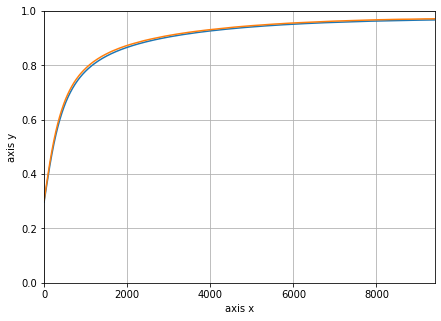

In [17]:
subjs = ['sam', 'tabitha', 'chloe', 'blanche', 'b01', 'b02', 'b03', 'b04', 'b05']
sps = ['monkey', 'monkey', 'monkey', 'monkey', 'human', 'human', 'human', 'human', 'human']

for pos in [True, False]: # with and without posterior
    bestTrains = np.zeros((9,5))
    bestTests = np.zeros((9,5))
    allPerfs = []
    for sind, subj in enumerate(subjs): # Loop through subjects
        # setup data
        featureChoiceLikelihood, objectChoice, objectChoice0 = setupData(sps[sind], subj, pos)
        availInds = np.arange(objectChoice.shape[0])

        # Five fold cross-validation
        for i in range(5):
            np.random.seed(123)
            if availInds.shape[0] > 0.3*objectChoice.shape[0]:
                testInds = np.random.choice(availInds, size=int(0.2*objectChoice.shape[0]), replace=False)
            else:
                testInds = availInds
            availInds = np.setdiff1d(availInds, testInds)

            # Train classifier
            btr, bte, allPerf = trainNet(i, featureChoiceLikelihood, objectChoice, objectChoice0, testInds)
            bestTrains[sind, i] = btr
            bestTests[sind, i] = bte
            allPerfs.append(allPerf)
    if pos:
        allPerfsP = allPerfs

### Write results to file

In [18]:
results = {'allPerfs':allPerfs, 'allPerfsP':allPerfsP}
with open('analysis/objPredPerfs.pickle', 'wb') as f:
    pickle.dump([results], f)
    
results = {'bestTrains':bestTrains, 'bestTests':bestTests}
with open('analysis/all_objPredPerf.pickle', 'wb') as f:
    pickle.dump([results], f)

### Plot performance

In [22]:
def getPM(N):
    if N == 1:
        return 1
    elif N > 1:
        x = np.zeros([N])
        x[0] = 1
        for i in np.arange(1,N):
            x[i] = -1 * x[i-1]
        return x

Text(0, 0.5, 'Chosen object likelihood')

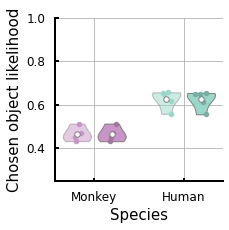

In [26]:
import numpy.random as npr

# Load performance
with open('analysis/all_objPredPerf.pickle', 'rb') as f:
    results = pickle.load(f)
    
speciesColor = np.array([[201,148,199],[153,216,201]])/255

vpWidth = 0.35

fig, ax = plt.subplots(ncols=1,nrows=1,sharex=True,sharey=True,figsize=(3,3))


for subjType in range(2): # loop through species
        if subjType == 0:
            sInds = [0,1,2,3]
        else:
            sInds = [4,5,6,7,8]
        
        dataTrain = np.mean(results[0]['bestTrains'], axis = 1)[sInds]
        dataTest = np.mean(results[0]['bestTests'], axis = 1)[sInds]

        for pType in range(2): # training vs test set performance
            if pType == 0:
                x1 = subjType+1-vpWidth/1.8
                data = dataTrain
            else:
                x1 = subjType+1+vpWidth/1.8
                data = dataTest
            vp1 = ax.violinplot(data,[x1],showextrema=False,widths=0.9*vpWidth)

            for pc in vp1['bodies']:
                pc.set_facecolor(speciesColor[subjType])
                pc.set_edgecolor('gray')
                pc.set_alpha(0.5+pType*0.5)

            x = npr.rand(len(sInds)) * (vpWidth) * (0.2)
            pm = getPM(x.shape[0])
            x = np.multiply(x,pm) + x1
            ax.scatter(x,data,s=20,color=speciesColor[subjType]*(1-0.2*pType))

            ax.scatter(x1,np.mean(data),color='white',s=30,edgecolors='gray') 

# Prettify
ax.set_ylim([0.25,1])

ax.set_axisbelow(True)
ax.grid(which='major', axis='both') 
ax.tick_params(axis='both',labelsize= 12,direction='in',pad=10)

# change all spines
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# increase tick width
ax.tick_params(width=2)

ax.set_xlabel('Species', fontsize= 15)
ax.set_xticks([1,2])
ax.set_xticklabels(['Monkey','Human'])
    
ax.set_ylabel('Chosen object likelihood', fontsize= 15)

## Statistical testing and final plots

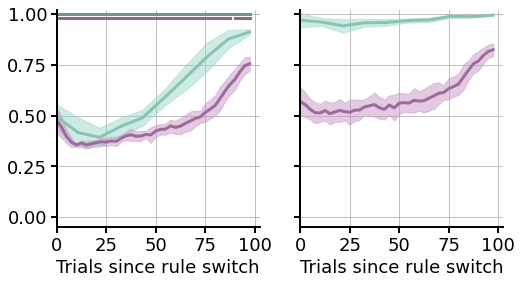

In [59]:
from scipy import stats

speciesColor = np.array([[153,216,201], [201,148,199]])/255
subjs = ['sam', 'tabitha', 'chloe', 'blanche','b01', 'b02', 'b03', 'b04', 'b05']
sps = ['monkey', 'monkey', 'monkey', 'monkey', 'human', 'human', 'human', 'human', 'human']

# Load performance
with open('analysis/objPredPerfs.pickle', 'rb') as f:
    [results] = pickle.load(f)

# Helper function for bootstrap statistical testing
def calcBootstrpSS(data):
    data = np.array(data)
    s = stats.ttest_1samp(data, 0.25)
    t = s.statistic

    data_hat = data-np.mean(data) + 0.25
    t_stars = []
    for i in range(10000):
        data_samp = np.random.choice(data_hat,size=data.shape[0])
        s = stats.ttest_1samp(data_samp, 0.25)
        t_stars.append(s.statistic)

    return t, t_stars

fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(4*2,4), sharey=True)

species = np.unique(sps)
for spc, sp in enumerate(species): # Loop through species        
    if sp == 'monkey':
        numBlockBins = 40
    else:
        numBlockBins = 10
    sinds = np.where(np.array(sps) == sp)[0]
    probabilityPred = np.zeros([numBlockBins, sinds.size, 2])

    for pType in range(2): # results based on / not based on posterior
        if pType == 0:
            allPerfs = results['allPerfs']
        else:
            allPerfs = results['allPerfsP']
        for scnt, sind in enumerate(sinds): # loop through subjects
            subj = subjs[sind]
            
            mp = []
            # Find best model for subject
            for i in range(sind*5, (sind+1)*5):
               mp.append(np.mean(allPerfs[i]))
            best = np.argmax(mp) + sind*5
        
            # Load rules 
            _, _, _, rules = pickle.load( open( 'rawData/forObjectPred/'+sp+'/'+subj+'_objPredFromFeatPred.pickle', "rb" ) )

            # Collect performance by rule block
            r = rules[0]
            P_block = []
            Ps = []
            for i in range(allPerfs[best].shape[0]):
                if r == rules[i]:
                    P_block.append(allPerfs[best][i])
                else:
                    Ps.append(P_block)
                    P_block = [allPerfs[best][i]]
                    r = rules[i]

            # Count correct predictions
            probCnts = np.zeros([numBlockBins, 2])
            for blk in range(len(Ps)):
                for t in range(1,len(Ps[blk])):
                    nt = int(np.floor(t/len(Ps[blk])*numBlockBins))
                    probCnts[nt,0] += Ps[blk][t]
                    probCnts[nt,1] += 1
            # Compute performance accuracy counts
            probabilityPred[:, scnt, pType] = probCnts[:,0]/probCnts[:,1]


        # Plot performance summary
        meanSub = np.mean(probabilityPred[:,:, pType],axis=1)
        stdSub = np.std(probabilityPred[:,:, pType],axis=1)
        xSub = np.arange(0, 40, 1+3.333*(1-spc))
        loSub = meanSub-stdSub
        hiSub = meanSub+stdSub
        ax[pType].plot(xSub,meanSub,linewidth=3,color=speciesColor[spc]*0.9-0.1*spc)
        ax[pType].fill_between(xSub,loSub,hiSub,color=speciesColor[spc],alpha=0.5)

        # Test and plot statistical significance
        if pType == 0:
            sig = []
            for i in range(probabilityPred.shape[0]):
                data = np.squeeze(probabilityPred[i,:, pType])
                t, t_stars = calcBootstrpSS(data)
                sig.append(np.mean(t_stars>=t))

            start = -1
            for ic, i in enumerate(xSub):
                if sig[ic] < 0.05:
                    if start == -1:
                        start = i
                else:
                    if start > -1:
                        ax[pType].plot([start, i],[1-0.02*spc,1-0.02*spc],'-',linewidth=3,color=speciesColor[spc]*0.7)
                        start = -1

                if start > -1:
                    ax[pType].plot([start, i],[1-0.02*spc,1-0.02*spc],'-',linewidth=3,color=speciesColor[spc]*0.7)

    # To save results to file
    if sp == 'monkey':
        probabilityPredM = probabilityPred
        sigM = sig
    else:
        probabilityPredH = probabilityPred
        sigH = sig
    #######################

# Prettify
for pType in range(2): 

    ax[pType].set_xticks([0,10,20,30,40])
    ax[pType].set_yticks([0,0.25,0.5,0.75,1])
    ax[pType].set_xticklabels([0,25,50,75,100])
    ax[pType].set_ylim([-0.05,1.02])

    ax[pType].set_xlim([0,41])
    ax[pType].set_xlabel('Trials since rule switch',fontsize=18)

    ax[pType].tick_params(axis='both',labelsize= 18,direction='out',width=2, length=6)
    # change all spines
    for axis in ['top','bottom','left','right']:
        ax[pType].spines[axis].set_linewidth(2)

    ax[pType].spines['right'].set_visible(False)
    ax[pType].spines['top'].set_visible(False)

    ax[pType].set_axisbelow(True)
    ax[pType].grid(which='major', axis='both')


# plt.subplots_adjust(wspace=0.4,
#                 hspace=0.0)
# plt.savefig('objPred.eps', format='eps')

Save results
with open('analysis/objPredSummary.pickle', 'wb') as f:
    pickle.dump([probabilityPredM, probabilityPredH, sigM, sigH], f)



